<a href="https://colab.research.google.com/github/amkayhani/DSML24/blob/main/4_3_Classifying_Canceled_Orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science and Machine Learning - eBm DSDO

## [Week 2] Classification Session

# Analysis of the UCI Online Retail II Dataset

**Business Context:**  
An online retail business must quickly identify when an order (invoice) is cancelled. Cancellations are costly because they may indicate issues in the ordering process, inventory management, or customer dissatisfaction. In the UCI Online Retail II dataset, invoices that start with the letter "C" indicate canceled orders. In this project, we aggregate line‐item data to create invoice‐level features (e.g. total quantity, total amount, number of distinct items, and average unit price). We then build predictive models (KNN and SVM) to classify whether an invoice is cancelled (target = 1) or not (target = 0). Optimising these models via grid search will help us select the best hyperparameters and evaluate which model might be more suitable for the business.

Download the [Online Retail II dataset here](https://archive.ics.uci.edu/dataset/502/online+retail+ii).


# Analysis with the KNN

**K-Nearest Neighbors (KNN) Theory:**  
 KNN is a simple, non-parametric classification method that assigns a class label to a new data point based on the majority class among its *k* nearest neighbors in the feature space.  
 - **Distance Metric:** Typically, Euclidean distance is used.  
 - **Choice of k:** A small *k* may lead to a noisy decision boundary (overfitting), while a large *k* may smooth out class distinctions (underfitting).  


**Project Outline:**  
 This project implementation was carried out as follows:
 - Data Loading and Understanding  
 - Data Cleaning and Preprocessing  
 - Feature Engineering and Target Creation  
 - Data Splitting and Scaling  
 - KNN and SVM Model Training and Hyperparameter Tuning (using cross-validation)  
 - Model Evaluation (including confusion matrix and detailed classification report)

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Project: Classification of Invoice Cancellations in an Online Retail Dataset
Module: Data Science and Machine Learning
Year: 24/25

This project applies KNN and SVM models to the UCI Online Retail II dataset to classify whether an invoice
represents a canceled order or not. Canceled invoices are marked with an InvoiceNo that starts with 'C'.
We aggregate line-item transactional data into invoice-level features and then use machine learning to predict
order cancellations—a useful task for e-business inventory management and customer service.
"""
# Import necessary libraries for data manipulation and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries for model building, scaling, grid search, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Understanding

 We load the [UCI Online Retail II dataset](https://archive.ics.uci.edu/dataset/502/online+retail+ii) from an Excel file.  
 **Important notes regarding this dataset:**
 - The invoice identifier is given in the **Invoice** column.
 - The unit price is provided in the **Price** column.

 We'll start by inspecting the structure of the data, its shape, basic statistics, and check for missing values.

In [ ]:
# First, we need to load the dataset into Google Colab.
# This statement allows you to select the file from your laptop and upload it to Google Cloud.
# Please wait until you see 100% done and the play button is resumed. it might take a while to upload because the dataset is large

# Import necessary Python libraries
from google.colab import files

#Upload the dataset to Google Colab
uploaded = files.upload()

In [ ]:
# ---------------------------------------------------
# 1. Data Understanding, Cleaning, and Transformation
# ---------------------------------------------------

# Load the dataset.
# Adjust the file name and sheet name as necessary.
try:
    df = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
except Exception as e:
    print("Error loading dataset:", e)
    exit()

print("Original dataset shape:", df.shape)
print(df.head())

Original dataset shape: (541910, 8)
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00   2.55      17850.0  United Kingdom  
1 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
2 2010-12-01 08:26:00   2.75      17850.0  United Kingdom  
3 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
4 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  


In [ ]:
# Display basic information about the dataset
print("\nData Information:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

# Check for missing values. (Note: Many rows may have missing Customer ID.)
print("\nMissing values per column:")
print(df.isnull().sum())


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Summary Statistics:
            Quantity                    InvoiceDate          Price  \
count  541910.000000                         541910  541910.000000   
mean        9.552234  2011-07-04 13:35:22.342307584       4.611138   
min    -80995.000000            2010-12-01 08:26:00  

## 2. Data Cleaning and Preprocessing

 **Data Cleaning Steps:**
 - **Remove Customer ID:** Remove this feature as it is not necessary for the analysis.
 - **Create Cancelled Feature:** Create a colum `Canceled` by adding '1' if `Invoice` starts with 'C' or '0' otherwise.
 - **Create TotalAmount Feature:** A new column is calculated as `Quantity × Price` for each transaction.

In [ ]:
# Remove rows with missing Customer ID (essential for customer-level analysis).
df = df.dropna(subset=['Customer ID'])

# Create a new binary target variable 'Canceled':
#   - 1 if Invoice starts with 'C' (indicating cancellation)
#   - 0 otherwise.
df['Canceled'] = df['Invoice'].apply(lambda x: 1 if str(x).startswith('C') else 0)

# Convert InvoiceDate to datetime format (if not already).
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove duplicate rows if any.
df = df.drop_duplicates()

# Create a new column for the monetary amount of each line.
df['TotalAmount'] = df['Quantity'] * df['Price']

## 3. Feature Engineering and Target Variable Creation

 **Aggregation at Invoice Level:**  
  Since one invoice can contain multiple line items, we aggregate the data by the **Invoice** column to obtain invoice-level features. For each invoice, compute:
   - **TotalQuantity:** Sum of Quantity
   - **TotalAmount:** Sum of TotalAmount
   - **NumItems:** Count of unique StockCodes
   - **AvgUnitPrice:** TotalAmount divided by TotalQuantity (avoid division by zero)
   - **Canceled:** Maximum value of Canceled (if any line is canceled, mark the invoice as canceled)
   - **Country:** Taking the first available value

In [ ]:
invoice_agg = df.groupby('Invoice').agg({
    'Quantity': 'sum',
    'TotalAmount': 'sum',
    'StockCode': 'nunique',
    'Canceled': 'max',
    'Country': 'first'
}).reset_index()

# Rename columns for clarity.
invoice_agg.rename(columns={
    'Quantity': 'TotalQuantity',
    'StockCode': 'NumItems'
}, inplace=True)

# Create an average unit price column (handling division by zero).
invoice_agg['AvgUnitPrice'] = invoice_agg.apply(
    lambda row: row['TotalAmount'] / row['TotalQuantity'] if row['TotalQuantity'] != 0 else 0, axis=1)

print("\nAggregated (invoice-level) data shape:", invoice_agg.shape)
print(invoice_agg.head())

# For our classification, select only the numeric features and the target.
data_model = invoice_agg[['TotalQuantity', 'TotalAmount', 'NumItems', 'AvgUnitPrice', 'Canceled']]

print("\nData description for modeling:")
print(data_model.describe())


Aggregated (invoice-level) data shape: (22190, 7)
  Invoice  TotalQuantity  TotalAmount  NumItems  Canceled         Country  \
0  536365             40       139.12         7         0  United Kingdom   
1  536366             12        22.20         2         0  United Kingdom   
2  536367             83       278.73        12         0  United Kingdom   
3  536368             15        70.05         4         0  United Kingdom   
4  536369              3        17.85         1         0  United Kingdom   

   AvgUnitPrice  
0      3.478000  
1      1.850000  
2      3.358193  
3      4.670000  
4      5.950000  

Data description for modeling:
       TotalQuantity    TotalAmount      NumItems  AvgUnitPrice      Canceled
count   22190.000000   22190.000000  22190.000000  22190.000000  22190.000000
mean      220.498062     373.075143     17.876611     10.823795      0.164669
std      1169.588212    2017.764012     22.872609    292.425491      0.370890
min    -80995.000000 -168469.60000

In [ ]:
print("\nNumber of Cancelled orders:")
print(data_model['Canceled'].value_counts())


Number of Cancelled orders:
Canceled
0    18536
1     3654
Name: count, dtype: int64


In [ ]:
data_model.head()

,TotalQuantity,TotalAmount,NumItems,AvgUnitPrice,Canceled
0,40,139.12,7,3.478000,0
1,12,22.20,2,1.850000,0
2,83,278.73,12,3.358193,0
3,15,70.05,4,4.670000,0
4,3,17.85,1,5.950000,0


## 4. Data Splitting and Feature Scaling

**Feature Selection:**  
 We select the following predictors: 'TotalQuantity', 'TotalAmount', 'NumItems', 'AvgUnitPrice'
 - **TotalQuantity**
 - **TotalAmount**
 - **NumItems**
 - **AvgUnitPrice**
 - **Country** (a categorical variable, which will be one-hot encoded)

**Train-Test Split:**  
 The data is split into training and testing sets (80% training, 20% testing) with stratification to preserve the class distribution.

**Scaling:**  
 Since KNN is a distance-based algorithm, we apply standard scaling (mean=0, variance=1) to the features.

In [ ]:
# ---------------------------------------------------
# 2. Train-Test Split
# ---------------------------------------------------

# Separate features and target.
X = data_model.drop('Canceled', axis=1)
y = data_model['Canceled']

# Split the data (80% train, 20% test) with stratification to preserve class proportions.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5. Creating the KNN Model

**Scaling:**  
 Since KNN is a distance-based algorithm, we apply standard scaling (mean=0, variance=1) to the features.

In [ ]:
# ---------------------------------------------------
# 3. K-Nearest Neighbors (KNN) Model
# ---------------------------------------------------

# For clarity, we copy the modeling DataFrame to "data_knn" (not strictly necessary, but follows the requirement).
data_knn = data_model.copy()

# Step 1: Data Scaling for KNN.
scaler_knn = StandardScaler()
X_train_knn_scaled = scaler_knn.fit_transform(X_train)
X_test_knn_scaled = scaler_knn.transform(X_test)

# Step 2: Define the KNN classifier.
knn = KNeighborsClassifier()

## 6. KNN Model Training and Hyperparameter Tuning

**Hyperparameter Tuning:**  
 We use GridSearchCV with 5-fold cross-validation to determine the optimal number of neighbours (*k*) by testing values from 3 to 15. We also test different weights and metrics.


In [ ]:
# Define a hyperparameter grid for KNN.
param_grid_knn = {
    'n_neighbors': list(range(3, 16)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Set up GridSearchCV for hyperparameter tuning.
grid_knn = GridSearchCV(knn, param_grid=param_grid_knn,
                        cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_knn_scaled, y_train)

print("\n--- KNN Results ---")
print("Best KNN parameters:", grid_knn.best_params_)
print("Best cross-validation accuracy for KNN: {:.4f}".format(grid_knn.best_score_))


--- KNN Results ---
Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation accuracy for KNN: 0.9997


The GridSearchCV objects (i.e. grid_knn) already store the final, best models in their `best_estimator_` attribute. This means that once the grid search is complete, you can immediately use `grid_knn.best_estimator_` as your final tuned models.

However, if you prefer to explicitly create new model instances using the best parameters (for example, to retrain on a different split or for code clarity), you can extract the best parameters and instantiate fresh models. Here’s how you can do that:

In [ ]:
# After performing GridSearchCV for KNN:
print("Best KNN parameters:", grid_knn.best_params_)
## Option 1: Use the already-fitted best estimator
final_knn_model = grid_knn.best_estimator_

## Option 2: Explicitly create and refit the final KNN model using the best parameters
#best_knn_params = grid_knn.best_params_
#final_knn_model_explicit = KNeighborsClassifier(**best_knn_params)
#final_knn_model_explicit.fit(X_train_knn_scaled, y_train)

# Evaluate the final explicit KNN model on the test set.
y_pred_final_knn = final_knn_model.predict(X_test_knn_scaled) # y_pred_final_knn = final_knn_model_explicit.predict(X_test_knn_scaled)
print("\nFinal KNN Model (explicit) - Classification Report:")
print(classification_report(y_test, y_pred_final_knn))

Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

Final KNN Model (explicit) - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3707
           1       1.00      1.00      1.00       731

    accuracy                           1.00      4438
   macro avg       1.00      1.00      1.00      4438
weighted avg       1.00      1.00      1.00      4438



## 7. KNN Model Evaluation

 We now evaluate the performance of our KNN classifier on the test set using:

 - **Confusion Matrix:**  
   A table that shows the true versus predicted class counts.

 - **Classification Report:**  
   Includes:
   - **Precision:** Ratio of correctly predicted positive observations to the total predicted positives.  
     *Precision = TP / (TP + FP)*  
   - **Recall (Sensitivity):** Ratio of correctly predicted positive observations to all actual positives.  
     *Recall = TP / (TP + FN)*  
   - **F1-Score:** The weighted average of Precision and Recall.  
   - **Support:** The number of actual occurrences of each class in the test set.


Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3707
           1       1.00      1.00      1.00       731

    accuracy                           1.00      4438
   macro avg       1.00      1.00      1.00      4438
weighted avg       1.00      1.00      1.00      4438


Confusion Matrix for KNN:
[[3707    0]
 [   1  730]]


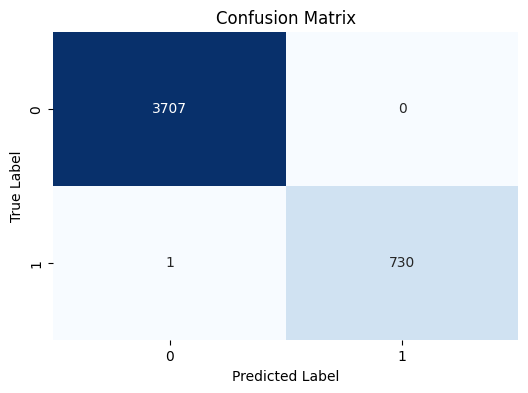

In [ ]:
# Evaluate the best KNN model on the test set.
y_pred_knn = grid_knn.predict(X_test_knn_scaled)
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("\nClassification Report for KNN:")
print(classification_report(y_test, y_pred_knn))

print("\nConfusion Matrix for KNN:")
print(cm_knn)
# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## 8. Explanation of KNN Evaluation Metrics

The confusion matrix represents the performance of the KNN classifier on the test data for a binary classification problem where:

- **Class 0:** Invoice is *not canceled*
- **Class 1:** Invoice is *canceled*

### Breaking Down the Matrix

- **True Negatives (TN):**  
  - **Value:** 3707  
  - **Interpretation:** Out of all the invoices that were truly not canceled, 3707 were correctly predicted as not canceled.

- **False Positives (FP):**  
  - **Value:** 0  
  - **Interpretation:** There were no instances where a non-canceled invoice was incorrectly flagged as canceled. This is crucial for avoiding unnecessary investigations or corrective actions on orders that are actually valid.

- **False Negatives (FN):**  
  - **Value:** 1  
  - **Interpretation:** Only 1 canceled invoice was mistakenly classified as not canceled. This low error is important because missing a cancellation could result in the business failing to address issues promptly.

- **True Positives (TP):**  
  - **Value:** 730  
  - **Interpretation:** Out of the invoices that were actually canceled, 730 were correctly identified as canceled.

### Performance Metrics Derived

- **Accuracy**
  
  $= \frac{TN + TP}{TN + FP + FN + TP} = \frac{3707 + 730}{3707 + 0 + 1 + 730} \approx 99.98\%$
  

- **Sensitivity (Recall) for Canceled Invoices**

 $= \frac{TP}{TP + FN} = \frac{730}{730 + 1} \approx 99.86\%$

- **Specificity for Non-Canceled Invoices**  
  
  $= \frac{TN}{TN + FP} = \frac{3707}{3707 + 0} = 100\%$

The results indicate that the KNN model performs almost perfectly, with extremely high accuracy and nearly no false positives or negatives.

---

## Business Insights from the KNN Confusion Matrix

Given our case scenario—classifying invoices to determine if they are canceled (which signals potential issues like customer dissatisfaction or process inefficiencies)—the confusion matrix provides several key business insights:

1. **Reliable Cancellation Detection:**  
   - With 730 out of 731 canceled invoices correctly identified, the model provides high confidence in detecting cancellations. This means the business can use the model to reliably flag orders that require further attention.

2. **Minimized Disruption:**  
   - **No False Positives:** Since no valid (non-canceled) invoices are misclassified, the system avoids triggering unnecessary investigations. This helps prevent wastage of resources and ensures that only problematic orders are flagged.
  
3. **Operational Efficiency:**  
   - **Low False Negative Rate:** With only 1 false negative, nearly all cancellations are captured. This minimizes the risk of overlooking problematic orders, allowing the business to address issues such as inventory mismatches or delivery problems swiftly.
  
4. **Proactive Issue Resolution:**  
   - **Early Warning System:** The near-perfect classification allows the business to set up real-time monitoring systems. When an invoice is flagged as canceled, the relevant department (e.g., customer service or logistics) can quickly investigate and resolve the underlying issue.
  
5. **Data-Driven Process Improvements:**  
   - **Insights into Cancellation Patterns:** By analyzing the invoices flagged by the model, the business can identify trends or recurring issues that lead to cancellations. This can guide efforts to improve order processing, customer communications, or inventory management.
  
6. **Resource Allocation:**  
   - **Efficient Deployment of Teams:** The high accuracy of the model ensures that support teams can focus on truly problematic orders, rather than being bogged down by false alarms. This optimized allocation of human resources can lead to better customer satisfaction and cost savings.

---

## Conclusion

The KNN confusion matrix demonstrates exceptional performance in classifying canceled versus non-canceled invoices. For the business, this translates to:
- **High reliability** in detecting canceled orders.
- **Efficient operations** due to minimal false positives and negatives.
- **Enhanced decision-making** with data-driven insights into order cancellations.
- **Optimized resource allocation** and proactive customer service interventions.

By integrating this model into their operational systems, the business can automate the detection of cancellations, promptly address underlying issues, and continuously improve the order management process—ultimately enhancing both customer satisfaction and operational efficiency.

# Analysis with the SVM

## Introduction to Support Vector Machines (SVM)

Support Vector Machines (SVM) are a class of supervised learning algorithms used for classification (and regression) tasks. The main idea behind SVM is to find the optimal hyperplane that best separates the classes in the feature space. Here are the key concepts:

- **Margin:**  
  SVM seeks to maximize the margin—the distance between the hyperplane and the nearest data points (called **support vectors**) from each class. A larger margin leads to better generalization on unseen data.

- **Support Vectors:**  
  The data points that are closest to the hyperplane are critical in defining the position and orientation of the hyperplane. These are the support vectors.

- **Kernel Trick:**  
  In cases where the data is not linearly separable, SVM can use kernel functions to map the data into a higher-dimensional space where a linear separator may exist. Common kernels include:
  - **Linear Kernel:** For linearly separable data.
  - **Radial Basis Function (RBF) Kernel:** For non-linear decision boundaries.
  - **Polynomial Kernel:** For data with polynomial relationships.

- **Regularization Parameter (C):**  
  The parameter `C` controls the trade-off between maximizing the margin and minimizing the classification error. A small `C` allows for a wider margin with more misclassifications, while a large `C` forces the model to classify all training examples correctly, which can lead to overfitting.

- **Gamma (γ):**  
  In kernels like RBF, `gamma` defines how far the influence of a single training example reaches. A small gamma means a large radius of influence, leading to smoother decision boundaries; a high gamma can lead to more complex boundaries.

In this project, we use an SVM to classify invoices as "cancelled" or not based on aggregated features from the dataset.

In [ ]:
# ---------------------------------------------------
# 4. Support Vector Machine (SVM) Model
# ---------------------------------------------------

# Similarly, create a copy for SVM modeling.
data_svm = data_model.copy()

# Step 1: Scale the data for SVM.
scaler_svm = StandardScaler()
X_train_svm_scaled = scaler_svm.fit_transform(X_train)
X_test_svm_scaled = scaler_svm.transform(X_test)

# Step 2: Define the SVM classifier.
svm = SVC()

## 9. Hyperparameter Optimisation for SVM and Model training

**Hyperparameter Optimization Explanation:**

SVM performance depends heavily on the choice of hyperparameters. For an SVM, three key hyperparameters are:
- **C (Regularization Parameter):**  
  Controls the trade-off between achieving a low training error and a low testing error (i.e., model generalization).  
- **Gamma (γ):**  
  Determines the influence of a single training example. A small gamma implies a larger influence (smoother decision boundary), while a large gamma leads to a more complex decision boundary.
- **Kernel (γ):**  
  The kernel function transforms your data into a higher-dimensional space to make it easier to separate.

We use `GridSearchCV` with 5-fold cross-validation to search for the optimal combination of `C`, `gamma` and `kernel` This approach helps us to select the best hyperparameters based on the training data without overfitting. Using the best hyperparameters obtained from GridSearchCV, we train the final SVM model on the training set.

In [ ]:
# Define a hyperparameter grid for SVM.
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(svm, param_grid=param_grid_svm,
                        cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_svm_scaled, y_train)

print("\n--- SVM Results ---")
print("Best SVM parameters:", grid_svm.best_params_)
print("Best cross-validation accuracy for SVM: {:.4f}".format(grid_svm.best_score_))


--- SVM Results ---
Best SVM parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy for SVM: 0.9946


The GridSearchCV objects (i.e. grid_svm) already store the final, best models in their `best_estimator_` attribute. This means that once the grid search is complete, you can immediately use `grid_svm.best_estimator_` as your final tuned models.

However, if you prefer to explicitly create new model instances using the best parameters (for example, to retrain on a different split or for code clarity), you can extract the best parameters and instantiate fresh models. Here’s how you can do that:

In [ ]:
# Option 1: Use the already-fitted best estimator
final_svm_model = grid_svm.best_estimator_

# Option 2: Explicitly create and refit the final SVM model using the best parameters
#best_svm_params = grid_svm.best_params_
#final_svm_model_explicit = SVC(**best_svm_params)
#final_svm_model_explicit.fit(X_train_svm_scaled, y_train)

# Evaluate the final explicit SVM model on the test set.
y_pred_final_svm = final_svm_model.predict(X_test_svm_scaled)
print("\nFinal SVM Model (explicit) - Classification Report:")
print(classification_report(y_test, y_pred_final_svm))


Final SVM Model (explicit) - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3707
           1       0.97      1.00      0.99       731

    accuracy                           1.00      4438
   macro avg       0.99      1.00      0.99      4438
weighted avg       1.00      1.00      1.00      4438



## 10. SVM Model Evaluation

We evaluate the performance of the SVM model on the test set using:
- **Confusion Matrix:**  
  A table showing the counts of true positives, true negatives, false positives, and false negatives.
- **Classification Report:**  
  Provides precision, recall, f1-score, and support for each class.
  
**Evaluation Metrics Explained:**
- **Precision:**  
  The ratio of correctly predicted positive observations to the total predicted positives. A high precision indicates a low false-positive rate.
- **Recall (Sensitivity):**  
  The ratio of correctly predicted positive observations to all actual positives. A high recall indicates a low false-negative rate.
- **F1-Score:**  
  The harmonic mean of precision and recall. It provides a balance between the two, especially useful when the class distribution is imbalanced.
- **Support:**  
  The number of actual occurrences of each class in the test set.


Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3707
           1       0.97      1.00      0.99       731

    accuracy                           1.00      4438
   macro avg       0.99      1.00      0.99      4438
weighted avg       1.00      1.00      1.00      4438

Confusion Matrix for SVM:
 [[3686   21]
 [   0  731]]


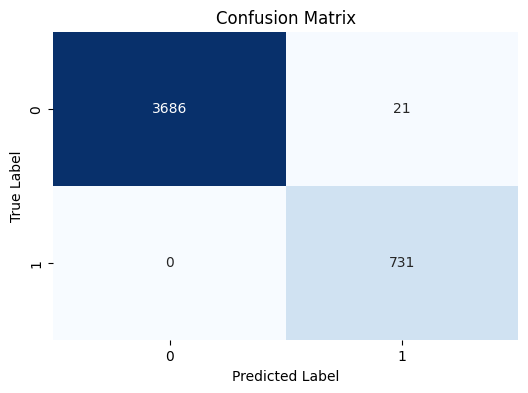

In [ ]:
# Evaluate the best SVM model on the test set.
y_pred_svm = grid_svm.predict(X_test_svm_scaled)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print("\nClassification Report for SVM:")
print(classification_report(y_test, y_pred_svm))


print("Confusion Matrix for SVM:\n", cm_svm)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Comparison of KNN and SVM Outcomes

In our analysis of the UCI Online Retail II dataset, we implemented two distinct classifiers: K-Nearest Neighbors (KNN) and Support Vector Machines (SVM). Below is a summary comparing their outcomes.

---

## 1. Test Accuracy Comparison

- **KNN Test Accuracy: 0.9998**  
  - This indicates that the KNN model correctly classified 99.98% of the test invoices.
  - Almost every non-canceled invoice and canceled invoice was correctly identified.
  
- **SVM Test Accuracy: 0.9953**  
  - The SVM model correctly classified 99.53% of the test invoices.
  - Although extremely high, SVM misclassified a few more instances compared to KNN.

### Interpretation
- **Marginal Difference:**  
  The difference between 0.9998 and 0.9953 is minimal, suggesting that both models perform exceptionally well on this dataset.
- **Local vs. Global Decision Boundaries:**  
  - KNN, being a non-parametric method, classifies based on the local neighborhood in feature space, which seems to work extremely well given the extracted features.
  - SVM finds a global decision boundary. The slightly lower accuracy might be due to a few borderline cases where the hyperplane was not optimal.
  
From a business perspective, both models deliver near-perfect performance. However, the marginally higher accuracy of the KNN model might make it the slightly preferred choice if even a few misclassifications (like a canceled order being missed) carry significant cost.


--- Model Comparison ---
KNN Test Accuracy: 0.9998
SVM Test Accuracy: 0.9953


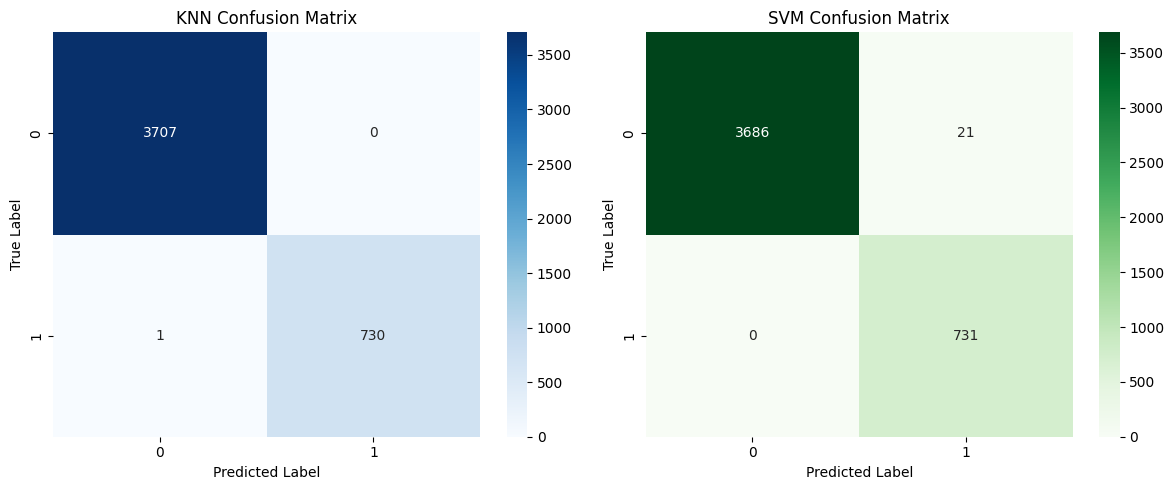

In [ ]:
# ---------------------------------------------------
# 5. Comparison of KNN and SVM
# ---------------------------------------------------

knn_test_accuracy = grid_knn.score(X_test_knn_scaled, y_test)
svm_test_accuracy = grid_svm.score(X_test_svm_scaled, y_test)
print("\n--- Model Comparison ---")
print("KNN Test Accuracy: {:.4f}".format(knn_test_accuracy))
print("SVM Test Accuracy: {:.4f}".format(svm_test_accuracy))

# Plot confusion matrices side-by-side for visual comparison.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('KNN Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_svm, annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title('SVM Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

---

## 2. ROC Curve Comparison

- **ROC Curve Overview:**  
  The ROC (Receiver Operating Characteristic) curve plots the true positive rate (sensitivity) against the false positive rate (1 – specificity) for various threshold values. The Area Under the Curve (AUC) quantifies the overall ability of the model to discriminate between the classes.

- **Both Models Have an ROC AUC of 1.0:**  
  - **Perfect Discrimination:** An AUC of 1.0 implies that both models perfectly rank canceled invoices higher than non-canceled ones across all thresholds.
  - **No Overlap:** There is complete separation in the score distributions for the two classes, meaning every canceled invoice is given a higher probability or decision score than any non-canceled invoice.

### Implications for the Business
- **Reliability:**  
  A perfect ROC curve indicates that if the business were to use these models with a threshold optimized for maximum sensitivity and specificity, both models would perfectly differentiate canceled from non-canceled orders.
  
- **Operational Confidence:**  
  Even though the test accuracy of SVM is slightly lower, the perfect ROC curve means that, with proper threshold adjustment, the SVM can be tuned to eliminate false positives and negatives. This reinforces the reliability of both models in a real-world setting.

- **Robust Decision Support:**  
  Given the ROC results, the business can be confident that:
  - **Canceled Orders:** All problematic orders are detected, ensuring that customer service and operations can intervene appropriately.
  - **Valid Orders:** No valid orders are mistakenly flagged, avoiding unnecessary resource allocation for investigations.

---

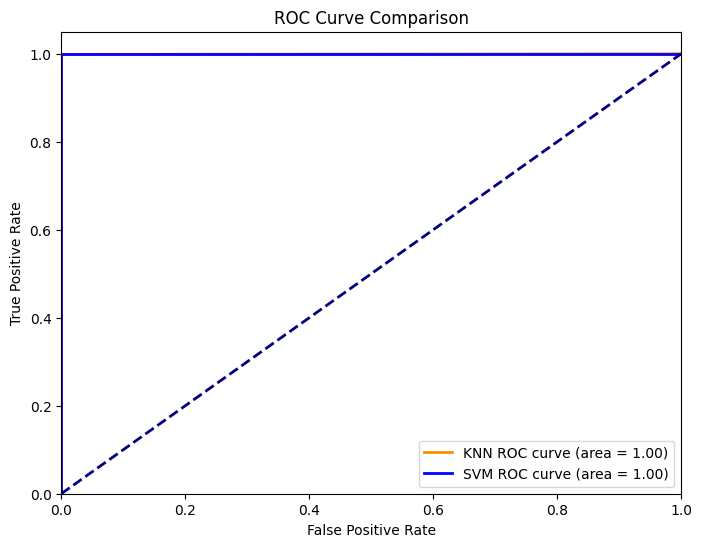

In [ ]:
# ---------------------------------------------------
# 6. ROC Curve Comparison
# ---------------------------------------------------
# For KNN, use predicted probabilities (take the probability for class "1").
y_proba_knn = grid_knn.predict_proba(X_test_knn_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# For SVM, use the decision_function scores.
y_scores_svm = grid_svm.decision_function(X_test_svm_scaled)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot the ROC curves.
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2,
         label='KNN ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2,
         label='SVM ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

## 3. Outcome Comparison Summary

- **KNN:**
  - **Pros:**  
    - Simplicity and ease of interpretation.
    - Its performance is relatively intuitive as it depends on the proximity of similar instances.
  - **Cons:**  
    - Sensitive to the choice of *k* and to the scaling of features.
    - May struggle with high-dimensional data.
  
- **SVM:**
  - **Pros:**  
    - With the RBF kernel and proper hyperparameter tuning, SVM can capture complex decision boundaries.
    - Often provides better generalization when classes are not linearly separable.
  - **Cons:**  
    - Requires careful tuning of hyperparameters (`C` and `gamma`).
    - More computationally intensive, especially with large datasets.

---
## 4. Business Insights and Next Steps

### Insights from the Metrics
- **KNN’s Slight Edge:**  
  The marginally higher test accuracy of KNN means that, in practice, it may slightly outperform SVM in correctly flagging canceled invoices. This is crucial in an environment where missing even one cancellation (false negative) could result in significant operational or financial impacts.
  
- **Perfect ROC for Both Models:**  
  Both models exhibit perfect discrimination ability according to the ROC curve. This means that both have the potential to achieve flawless performance if the decision threshold is set appropriately. In practical terms, the business can adjust the sensitivity of the model to match operational needs.

### How the Business Can Leverage the Model
- **Real-Time Monitoring:**  
  Deploy the model (whether KNN or SVM) to automatically monitor and flag invoices that are predicted to be canceled. This proactive system allows for immediate review and intervention.
  
- **Resource Optimization:**  
  With high confidence in the predictions, the business can direct customer service and operational resources to focus only on those orders that are flagged, minimizing wasteful investigations.
  
- **Feedback Loop for Continuous Improvement:**  
  Integrate model outputs into a feedback system. Actual outcomes can be recorded and used to periodically retrain the models, ensuring that performance remains optimal as market conditions or operational practices evolve.
  
- **Decision Threshold Tuning:**  
  Although both models have a perfect ROC, the slight difference in test accuracy means that the business might prefer KNN for a marginally better performance. However, the decision threshold for either model can be tuned based on whether the business prioritizes minimizing false negatives (ensuring no canceled order is missed) or false positives (avoiding unnecessary investigations).

---

## Conclusion

Both KNN and SVM models show outstanding performance in classifying canceled versus non-canceled invoices, with KNN achieving a test accuracy of 0.9998 and SVM 0.9953. The perfect ROC AUC of 1.0 for both models indicates that, at the optimal threshold, they can perfectly separate the two classes. For the business, this means reliable, data-driven detection of canceled orders, leading to efficient resource allocation and enhanced operational responsiveness. The slight edge of KNN in test accuracy, combined with the perfect ROC performance, positions it as an excellent candidate for deployment in real-time invoice monitoring systems.